In [21]:
import datetime
from math import sqrt, log

import numpy
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from domus_analytica.config import DomusSettings
from domus_analytica.data_clean import extract_info_to_table

config = DomusSettings(_env_file=".env.local")

# Extract Data and Preprocessing 

In [22]:
def data_preprocessing(data: pd.DataFrame):
    # Data preprocessing
    data["unit_price"] = data["price"] / data["exclusive_area"]
    data["completion_date_number"] = (
            pd.to_datetime(data["completion_date"]).astype(int)
            / (10 ** 9 * (24 * 60 * 60) * 365.25)
            + 1970
    )
    data["completion_date_decay"] = numpy.exp(
        (log(0.5) / 20.0) * (2025 - data["completion_date_number"])
    )
    data["min_distance_to_busy_area"] = data[
        ["distance_to_hakata", "distance_to_ohori_park", "distance_to_tenjin"]
    ].min(axis=1)
    data["floor_ratio"] = data["floor"] * 1.0 / data["total_floors"]
    data = pd.get_dummies(data, columns=["direction"], dtype="float32")
    data = pd.get_dummies(data, columns=["layout_main"], dtype="float32")
    data = pd.get_dummies(data, columns=["build_type"], dtype="float32")
    # Calculate decay
    b2 = log(0.1) / 2.0
    b5 = log(0.1) / 5.0
    data["dscore_to_busy_area"] = numpy.exp(b2 * data["min_distance_to_busy_area"])
    data["dscore_to_hakata"] = numpy.exp(b5 * data["distance_to_hakata"])
    data["dscore_to_ohori_park"] = numpy.exp(b5 * data["distance_to_ohori_park"])
    data["dscore_to_tenjin"] = numpy.exp(b5 * data["distance_to_tenjin"])
    return data


df = data_preprocessing(
    extract_info_to_table(
        config,
        {'search_time': datetime.datetime(2024, 4, 1, 14, 46, 31, 449000)}
    )
)
df.head()

,id,name,address,lat,lon,price,exclusive_area,common_area,completion_date,layout_storage_room,...,layout_main_3LDK,layout_main_3LK,layout_main_4LDK,build_type_RC,build_type_unknown,build_type_wood,dscore_to_busy_area,dscore_to_hakata,dscore_to_ohori_park,dscore_to_tenjin
0,/ms/chuko/fukuoka/sc_fukuokashihigashi/nc_7437...,モントーレブルー・ラ・メール Fukuoka,福岡県福岡市東区西戸崎２-1-30,33.6461037815746,130.3599501447,2080.0,57.25,11.04,2007-01-01,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.000592,0.019349,0.051156,0.038265
1,/ms/chuko/fukuoka/sc_fukuokashihigashi/nc_7460...,ファーネスト箱崎公園,福岡県福岡市東区松田２,33.6203572036973,130.443550474538,2080.0,69.85,38.10,2008-06-01,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.007204,0.139003,0.042349,0.087687
2,/ms/chuko/fukuoka/sc_fukuokashihigashi/nc_7250...,Asobi+ JGMヴェルデ香椎南弐番館,福岡県福岡市東区八田１,33.63406257298,130.456704058744,2490.0,93.33,24.55,2001-06-01,0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.000771,0.056849,0.018154,0.036323
3,/ms/chuko/fukuoka/sc_fukuokashiminami/nc_73552...,エイルヴィラクレアテュール井尻南II,福岡県福岡市南区曰佐２,33.540890670713,130.438664435095,2580.0,75.42,20.88,1999-05-01,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.001844,0.080603,0.027409,0.045273
4,/ms/chuko/fukuoka/sc_fukuokashihakata/nc_74582...,アンピール吉塚,福岡県福岡市博多区吉塚６,33.6075918806721,130.429482478425,2780.0,65.10,14.00,2000-11-01,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.061316,0.327364,0.096791,0.209101


# Train LinearRegression model to predict unit price

In [23]:
from itertools import chain
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

feature_prefixes = ["direction_", "layout_main_", "build_type_", "dscore_"]
features = list(set(chain(
    [
        "bus_station_count",
        "restaurant_count",
        "supermarket_count",
        "convenience_store_count",
        "drugstore_count",
        "park_count",
        "cafe_count",
        "floor",
        "total_floors",
        "floor_ratio",
        "common_area",
        "layout_storage_room",
        "exclusive_area",
        "completion_date_number",
        "monthly_fee_total",
    ],
    *(
        [col for col in df.columns if col.startswith(feature_prefix)]
        for feature_prefix in feature_prefixes
    )
)))
target = "unit_price"

print("Using features: {} to predict {}".format(",".join(features), target))

X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.1, random_state=123
)

model = Pipeline(steps=[("lr", LinearRegression())])
model.fit(X_train, y_train)
print(
    f"R-Square: Train={model.score(X_train, y_train)}, test={model.score(X_test, y_test)}"
)
print(
    f"単価のRMSE (万円): Train={sqrt(mean_squared_error(model.predict(X_train), y_train))}, test={sqrt(mean_squared_error(model.predict(X_test), y_test))}"
)

total_rmse_train = sqrt(
    mean_squared_error(
        model.predict(X_train) * X_train["exclusive_area"],
        y_train * X_train["exclusive_area"],
    )
)
total_rmse_test = sqrt(
    mean_squared_error(
        model.predict(X_test) * X_test["exclusive_area"],
        y_test * X_test["exclusive_area"],
    )
)
print(f"総金額のRMSE (万円): Train={total_rmse_train}, test={total_rmse_test}")
df["unit_price_estimate"] = model.predict(df[features])
df["price_estimate"] = df["unit_price_estimate"] * df["exclusive_area"]

Using features: direction_南東,drugstore_count,layout_main_2DK,build_type_unknown,layout_main_3LDK,dscore_to_tenjin,build_type_wood,park_count,layout_storage_room,direction_南,floor_ratio,direction_東,direction_南西,exclusive_area,common_area,completion_date_number,total_floors,convenience_store_count,layout_main_2LDK,restaurant_count,bus_station_count,direction_北,dscore_to_hakata,layout_main_4LDK,monthly_fee_total,cafe_count,direction_北東,dscore_to_ohori_park,build_type_RC,direction_北西,supermarket_count,layout_main_3LK,dscore_to_busy_area,floor,direction_西 to predict unit_price
R-Square: Train=0.814958070918075, test=0.8177815762409736
単価のRMSE (万円): Train=7.328939545104461, test=6.6360688728561215
総金額のRMSE (万円): Train=590.1155754752476, test=531.4509779117044


## Coefficients Analysis 

It's a LINEAR model! So we can roughly know the reason of the price estimation.

For example, the floor is 0.413716.
Which means for the same house, when you raise 1 floor (like 3F->4F), you need to pay 4137JPY for each $m^2$.

But it not always correct, there are positive or negative correlations between some variables, which will ultimately affect the results. 

For example: regardless of land prices, primary schools as basic infrastructure are distributed relatively evenly and may even be far from downtown areas. In this case, the number of primary schools has a negative impact on prices, but it does not mean that the existence of primary schools lowers land prices.


In [24]:
pd.DataFrame(
    zip(features, model[-1].coef_),
    columns=["features", "coefficients"],
).sort_values(by="features")

,features,coefficients
28,build_type_RC,4.044211e+00
3,build_type_unknown,3.016033e+00
6,build_type_wood,-7.060523e+00
20,bus_station_count,3.888987e+00
25,cafe_count,2.490087e-01
14,common_area,6.958364e-02
15,completion_date_number,1.171557e+00
17,convenience_store_count,9.787878e-02
21,direction_北,1.709846e+10
26,direction_北東,1.709846e+10


# Error Analysis

## Error Visualization for unit price

Mu=-0.05631772450327296 Std=7.261488264156387


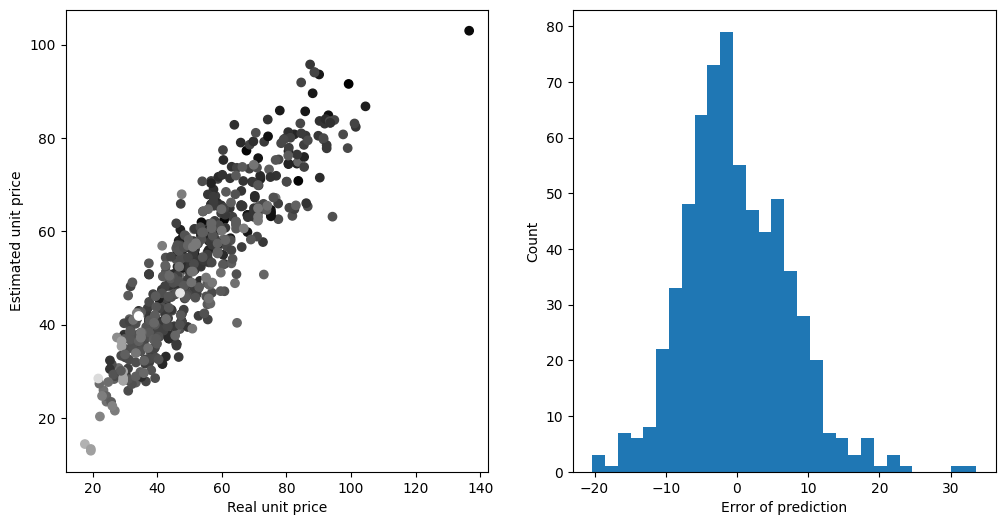

In [25]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12, 6))
[ax1, ax2] = fig.subplots(1, 2)
_ = ax1.scatter(df["unit_price"], df["unit_price_estimate"], c=df["exclusive_area"], cmap="gray")
ax1.set_xlabel("Real unit price")
ax1.set_ylabel("Estimated unit price")
unit_price_error = df["unit_price"] - df["unit_price_estimate"]
_ = ax2.hist(unit_price_error, bins=30)
ax2.set_xlabel("Error of prediction")
ax2.set_ylabel("Count")
print(f"Mu={unit_price_error.to_numpy().mean()} Std={unit_price_error.to_numpy().std()}")

## Error Analysis for Total Price

Mu=-4.782836823968818 Std=584.416742815084


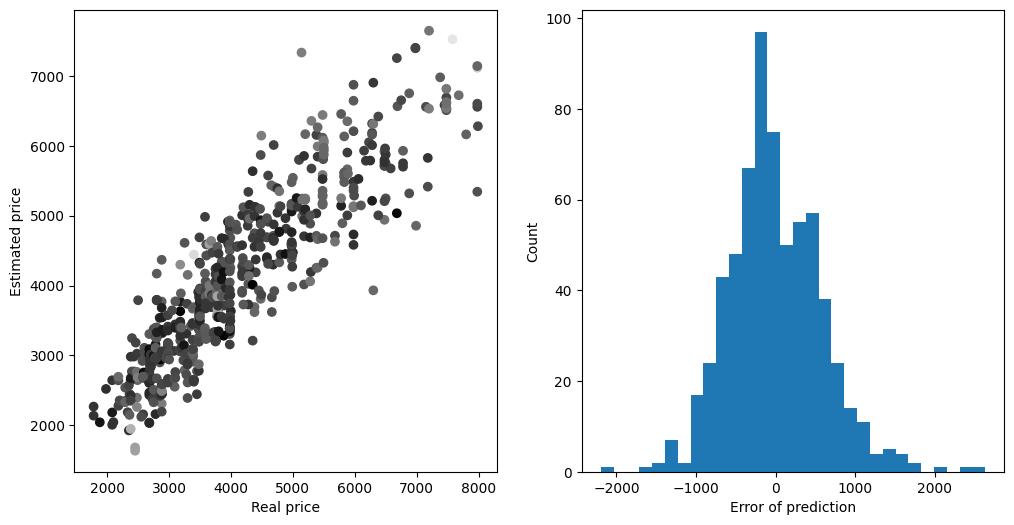

In [26]:
fig = plt.figure(figsize=(12, 6))
[ax1, ax2] = fig.subplots(1, 2)
_ = ax1.scatter(df["price"], df["price_estimate"], c=df["exclusive_area"], cmap="gray")
ax1.set_xlabel("Real price")
ax1.set_ylabel("Estimated price")
price_error = df["price"] - df["price_estimate"]
_ = ax2.hist(price_error, bins=30)
ax2.set_xlabel("Error of prediction")
ax2.set_ylabel("Count")
print(f"Mu={price_error.to_numpy().mean()} Std={price_error.to_numpy().std()}")

## Distribution for CP value

CP value is the ration between estimated price and real price.
It assumes that the model's predictions are fundamentally accurate, and that the prediction errors come from different sellers' psychological expectations.

When we have a model that also works well on the test set, we can use CP Value to estimate the profit margin.

Text(0, 0.5, 'Count')

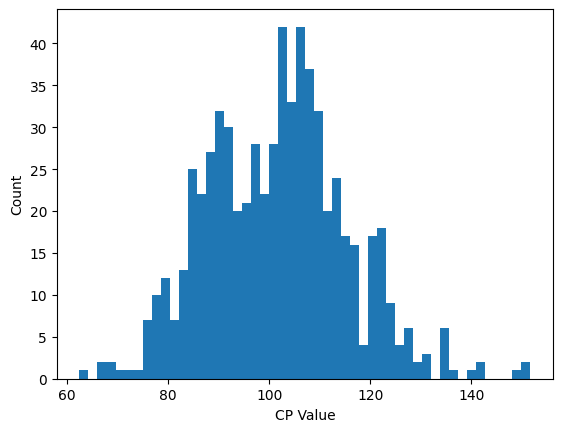

In [27]:
df["cp_value"] = df["price_estimate"] * 100.0 / df["price"]
_ = plt.hist(df["cp_value"], bins=50)
plt.xlabel("CP Value")
plt.ylabel("Count")

# Save The Result

Save the result to CSV file and order by CP value desc.

In [28]:
df.sort_values(by=["cp_value"], ascending=False).to_csv("data/result.csv", index=False)